In [7]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from hydra import compose, initialize

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parents[1]))

from maps_to_cosmology.encoder import Encoder
from maps_to_cosmology.datamodule import ConvergenceMapsModule

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initialize the config:

In [8]:
with initialize(config_path="../configs", version_base=None):
    cfg = compose("train_npe")

Instantiate the encoder using the checkpoint from a previous training run:

In [9]:
ckpt = "/data/scratch/blissWL_checkpoints/MVN_encoder.ckpt"
encoder = Encoder.load_from_checkpoint(ckpt, weights_only=False)
encoder.eval()
encoder.to(device)

Encoder(
  (train_rmse): RootMeanSquaredError()
  (train_pcc): PearsonCorrelationCoefficient()
  (val_rmse): RootMeanSquaredError()
  (val_scatter): ScatterPlot()
  (val_pcc): PearsonCorrelationCoefficient()
  (test_rmse): RootMeanSquaredError()
  (test_scatter): ScatterPlot()
  (test_pcc): PearsonCorrelationCoefficient()
  (net): ResNet(
    (stem): Sequential(
      (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (layer1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): ResidualBlock(
      (conv1): Conv2d(32, 64, ke

Instantiate the test dataloader:

In [10]:
# this cell takes approximately 3 minutes
datamodule = ConvergenceMapsModule(
    data_dir=cfg.paths.data_dir,
    batch_size=cfg.convergence_maps.batch_size,
    num_workers=cfg.convergence_maps.num_workers,
    val_split=cfg.convergence_maps.val_split,
    test_split=cfg.convergence_maps.test_split,
    seed=cfg.seed,
)
datamodule.setup()
test_loader = datamodule.test_dataloader()

Loading combined_batches.pt from /data/scratch/convergence_maps/lsst_y10_lognormal_with_noise
Loaded 99999 samples
Maps shape: torch.Size([99999, 256, 256, 5])
Params shape: torch.Size([99999, 6])
Train samples: 80001
Val samples: 9999
Test samples: 9999
Standardized cosmological parameters using TRAIN stats.
Train mean: tensor([ 0.3020,  0.0492,  0.8313,  0.6725,  0.9642, -1.1142])
Train std:  tensor([0.1704, 0.0060, 0.1402, 0.0629, 0.0801, 0.4615])


Load in the convergence maps from the test set and evaluate the encoder on them. Also load the correspoding cosmological parameters from the test set:

In [ ]:
# posterior_means = []
# posterior_stdevs = []
# true_params = []

# with torch.no_grad():
#     for maps, params in test_loader:
#         maps = maps.to(device)
        
#         out = encoder(maps)
#         posterior_mean = out[:, 0::2]
#         posterior_means.append(posterior_mean.cpu())
        
#         posterior_stdev = out[:, 1::2].clamp(-10, 10).exp().sqrt()
#         posterior_stdevs.append(posterior_stdev.cpu())
        
#         true_params.append(params)

# posterior_means = torch.cat(posterior_means, dim=0)
# posterior_stdevs = torch.cat(posterior_stdevs, dim=0)
# true_params = torch.cat(true_params, dim=0)

In [18]:
posterior_means = []
posterior_stdevs = []
true_params = []

with torch.no_grad():
    for maps, params in test_loader:
        maps = maps.to(device)
        out = encoder(maps)
        dist = encoder.var_dist.get_dist(out)
        posterior_mean = dist.loc
        posterior_std = torch.sqrt(
            torch.diagonal(dist.covariance_matrix, dim1=-2, dim2=-1)
        )
        posterior_means.append(posterior_mean.cpu())
        posterior_stdevs.append(posterior_std.cpu())
        true_params.append(params)

posterior_means = torch.cat(posterior_means, dim=0)
posterior_stdevs = torch.cat(posterior_stdevs, dim=0)
true_params = torch.cat(true_params, dim=0)

For each of the six cosmological parameters, create a scatterplot of the true parameter value versus the posterior mean. You'll want to use `plt.scatter()`. Arrange the six scatterplots in a 2x3 grid. How accurately do the posterior means approximate the true values? Explain why.

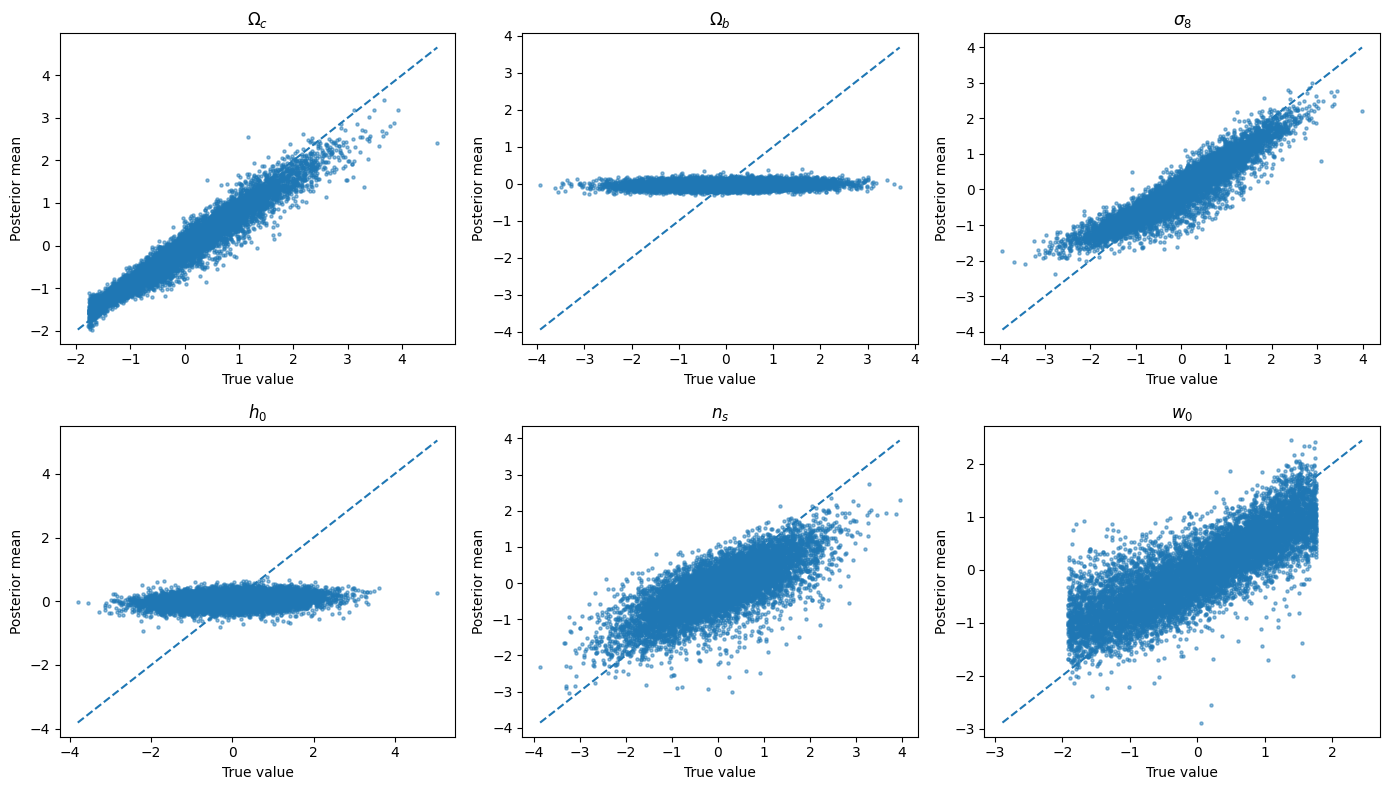

In [19]:
param_names = [
    r"$\Omega_c$", r"$\Omega_b$", r"$\sigma_8$",
    r"$h_0$", r"$n_s$", r"$w_0$"
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]

    x = true_params[:, i].numpy()
    y = posterior_means[:, i].numpy()

    ax.scatter(x, y, s=5, alpha=0.5)
    minv = min(x.min(), y.min())
    maxv = max(x.max(), y.max())
    ax.plot([minv, maxv], [minv, maxv], linestyle="--")

    ax.set_xlabel("True value")
    ax.set_ylabel("Posterior mean")
    ax.set_title(param_names[i])

plt.tight_layout()
plt.show()

Observations:
- `Clumpiness of matter` $\sigma_8$ is the best constrained parameter.
- $\Omega_c$ shows positive correlation with the true value.
- $w_0$ shows **almost no correlation** with the truth. Weak lensing maps cannot constrain it well.
- $\Omega_b$, $h_0$, and $n_s$ shows weak correlation with the true value.

---

We load in the convergence map used as a reference map in this paper (https://arxiv.org/pdf/2409.17975):

In [13]:
reference_map = np.load("reference_map.npy")
reference_params = [0.2664, 0.0492, 0.831, 0.6727, 0.9645, -1.0]

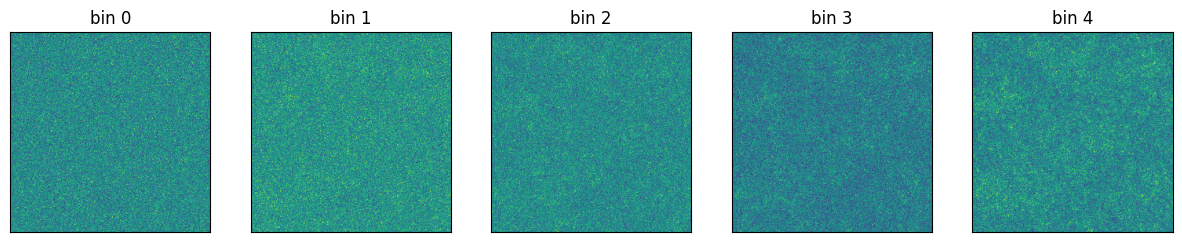

In [14]:
fig, ax = plt.subplots(1, 5, figsize = (15, 3))

for b in range(5):
    _ = ax[b].imshow(reference_map[...,b])
    _ = ax[b].set_title(f"bin {b}")
    _ = ax[b].set_xticks([])
    _ = ax[b].set_yticks([])

We plug this reference map into our trained encoder and plot the contours of the resulting variational distributions:

In [20]:
with torch.no_grad():
    reference_map_tensor = (
        torch.tensor(reference_map)
        .permute(2, 0, 1)          # [H,W,C] -> [C,H,W]
        .unsqueeze(0)              # -> [1,C,H,W]
        .to(device)
    )
    out = encoder(reference_map_tensor)
    posterior_mean = out[:, 0::2]
    posterior_stdev = out[:, 1::2].clamp(-10, 10).exp().sqrt()

In [21]:
num_samples = 1000
mean = posterior_mean.squeeze().cpu().numpy()
stdev = posterior_stdev.squeeze().cpu().numpy()
print("posterior_mean shape:", posterior_mean.shape)
print("posterior_stdev shape:", posterior_stdev.shape)
print("mean numpy shape:", mean.shape)
print("stdev numpy shape:", stdev.shape)
samples = np.random.normal(loc=mean, scale=stdev, size=(num_samples, 6))
df = pd.DataFrame(samples, columns=param_names)

g = sns.PairGrid(df, corner=True, diag_sharey=False)
g.map_diag(sns.kdeplot, fill=True)
g.map_lower(sns.kdeplot, levels=[0.05, 0.32, 1.0], fill=True, alpha=0.5)

for i in range(6):
    # Diagonal: vertical line at true value
    g.axes[i, i].axvline(reference_params[i], color='black', linestyle='--')
    
    # Lower triangle: vertical and horizontal dashed lines at true values
    for j in range(i):
        g.axes[i, j].axvline(reference_params[j], color='black', linestyle='--')
        g.axes[i, j].axhline(reference_params[i], color='black', linestyle='--')

posterior_mean shape: torch.Size([1, 14])
posterior_stdev shape: torch.Size([1, 13])
mean numpy shape: (14,)
stdev numpy shape: (13,)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1000, 6) and arg 1 with shape (14,).

Plot credible intervals:

Credible Interval Level: 90%
$\Omega_c$: Coverage =  0.954
$\Omega_b$: Coverage =  0.922
$\sigma_8$: Coverage =  0.960
$h_0$: Coverage =  0.896
$n_s$: Coverage =  0.924
$w_0$: Coverage =  0.936


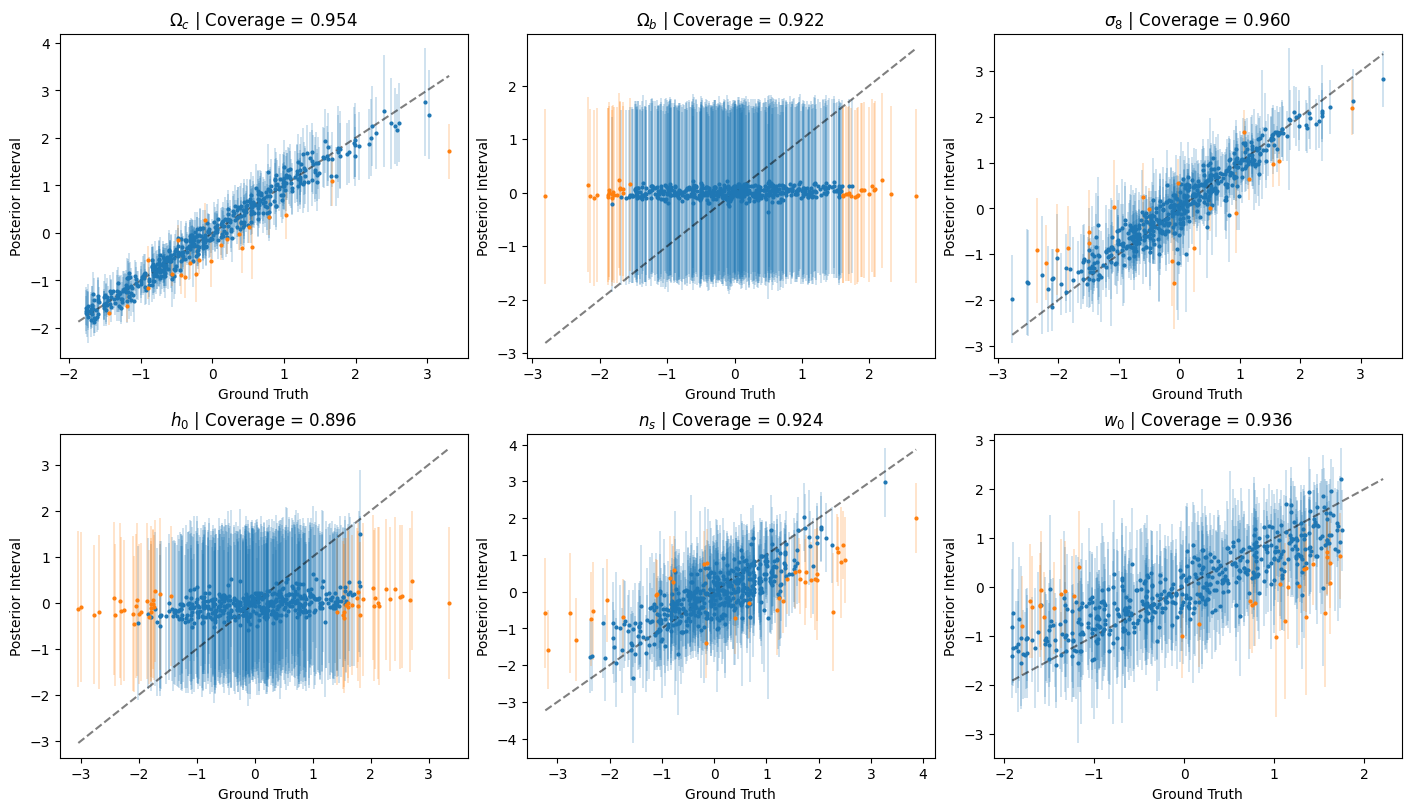

: 

: 

In [ ]:
z = 1.645                 # 90% credible interval
n_plot = 500
rng = np.random.default_rng(42)

mu   = posterior_means.detach().cpu().numpy()     # [N,6]
sig  = posterior_stdevs.detach().cpu().numpy()    # [N,6]
true = true_params.detach().cpu().numpy()         # [N,6]

N = true.shape[0]
idx = rng.choice(N, size=min(n_plot, N), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
axes = axes.ravel()

print(f"Credible Interval Level: 90%")
coverages = []
for j, name in enumerate(param_names):
    x = true[idx, j]
    y = mu[idx, j]
    yerr = z * sig[idx, j]
    lower = y - yerr
    upper = y + yerr
    covered = (x >= lower) & (x <= upper)
    cov = covered.mean()
    coverages.append(cov)
    print(f"{name}: Coverage = {cov: .3f}")

    ax = axes[j]
    ax.errorbar(
        x[covered], y[covered],
        yerr=yerr[covered],
        fmt="o",
        markersize=2,
        alpha=1,
        linewidth=0.3,
        capsize=0,
    )

    ax.errorbar(
        x[~covered], y[~covered],
        yerr=yerr[~covered],
        fmt="o",
        markersize=2,
        alpha=1,
        linewidth=0.3,
        capsize=0,
    )

    # y=x diagonal
    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], "k--", alpha=0.5)
    
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Posterior Interval")
    ax.set_title(f"{name} | Coverage = {coverages[j]:.3f}")

plt.show()
